# Travaux pratiques sur les réseaux d'eau

## 0. Données et fonctions du problème

### On charge dans l'environnement :
1. les fonctions de Python qui seront utilisées,
2. les données du problème,
3. les fonctions utilitaires du problème.

In [1]:
from numpy import random
import numpy as np

In [2]:
from Probleme_R import *
from Structures_N import *

In [3]:
from Visualg import Visualg
from Verification import Verification

###  On charge les prototypes d'algorithmes d'optimisation :

* **Gradient_F** : algorithme de gradient à pas fixe,
* **Newton_F** : algorithme de Newton à pas fixe.

 **Algorithm 9.2: Backtracking line search.**  
given a descent direction $ \Delta x$ for $f$ at $x \in \operatorname{dom}f$, $\alpha \in(0,0.5)$, $\beta \in (0,1)$, $t:=1$.  
while $ f(x+t \Delta x)>f(x)+\alpha t \nabla f(x)^{T} \Delta x $:  
  $ t:=\beta t $

In [4]:
def BacktrackingLineSearch(qc,critere,gradient,delta_x,
                           alpha = 0.1, beta = 0.9):
    step = 0.0006
    qc_new = qc + step * delta_x
    q = q0 + B.dot (qc_new)
    critere_new = 1/3*q.dot(r*q*abs(q)) + pr.dot(Ar.dot(q))
    while critere_new > critere + alpha * step * gradient.transpose()@delta_x:
        step *= beta
    return step

In [5]:
def Gradient_F(Oracle, x0, alpha0):
    
    from numpy.linalg import norm
    from time import process_time
    
    ##### Initialisation des variables
    
    iter_max = 10000
    gradient_step = alpha0
    threshold = 0.000001
    
    gradient_norm_list = []
    gradient_step_list = []

    critere_list = []
    
    time_start = process_time()
    
    x = x0

    ##### Boucle sur les iterations

    for k in range(iter_max):
        
        # Valeur du critere et du gradient
        critere, gradient = Oracle(x)
        
        # Test de convergence
        gradient_norm = norm(gradient)
        if gradient_norm <= threshold:
            break

        # Direction de descente
        direction = -gradient
        
        # Backracking Line search for step size
        #gradient_step = BacktrackingLineSearch(x,critere,gradient,direction)
        
        # Mise a jour des variables
        x = x + (gradient_step*direction)
        
        # Evolution du gradient, du pas, et du critere
        gradient_norm_list.append(gradient_norm)
        gradient_step_list.append(gradient_step)

        
        critere_list.append(critere)
    
    ##### Resultats de l'optimisation

    critere_opt = critere
    gradient_opt = gradient
    x_opt = x
    time_cpu = process_time() - time_start
    
    print()
    print('Iteration :', k)
    print('Temps CPU :', time_cpu)
    print('Critere optimal :', critere_opt)
    print('Norme du gradient :', norm(gradient_opt))

    # Visualisation de la convergence
    Visualg(gradient_norm_list, gradient_step_list, critere_list)
    
    return critere_opt, gradient_opt, x_opt, gradient_norm_list, gradient_step_list, critere_list

In [6]:
def Newton_F(Oracle, x0, alpha0):
    
    from numpy.linalg import norm
    from numpy.linalg import solve
    from time import process_time
    
    ##### Initialisation des variables    
    
    iter_max = 100
    gradient_step = alpha0
    threshold = 0.000001
    
    gradient_norm_list = []
    gradient_step_list = []
    critere_list = []

    time_start = process_time()
    
    x = x0

    ##### Boucle sur les iterations
    
    for k in range(iter_max):
        
        # Valeur du critere et du gradient
        critere, gradient, hessien = Oracle(x)

        # Test de convergence
        gradient_norm = norm(gradient)
        if gradient_norm <= threshold:
            break
        
        # Direction de descente
        direction = - solve(hessien, gradient)
        
        # Mise a jour des variables
        x = x + (gradient_step*direction)
        
        # Evolution du gradient, du pas, et du critere
        gradient_norm_list.append(gradient_norm)
        gradient_step_list.append(gradient_step)
        critere_list.append(critere)
   
    ##### Resultats de l'optimisation
    
    critere_opt = critere
    gradient_opt = gradient
    x_opt = x
    time_cpu = process_time() - time_start

    print()
    print('Iteration :', k)
    print('Temps CPU :', time_cpu)
    print('Critere optimal :', critere_opt)
    print('Norme du gradient :', norm(gradient_opt))
    
    # Visualisation de la convergence
    Visualg(gradient_norm_list, gradient_step_list, critere_list)
    
    return critere_opt, gradient_opt, x_opt,gradient_norm_list, gradient_step_list, critere_list

## I. Résolution du problème primal

In [7]:
from HydrauliqueP import HydrauliqueP

### I.a On écrit les oracles pour le problème primal d'optimisation :

* **OraclePG** : calcul de la fonction et du gradient,
* **OraclePH** : calcul de la fonction du gradient et du Hessien.

$ q=q^{(0)}+B q_{c} $  
  
$ z=r \bullet q \bullet|q| $
  
$ \nabla F\left(q_{C}\right)=B^{\top}(r \bullet q \bullet|q|)+B^{\top} A_{r}^{\top} p_{r} $  

$ F\left(q_{C}\right) = \frac{1}{3}\langle q, r \bullet q \bullet|q|\rangle+\left\langle p_{r}, A_{r} q\right\rangle $


In [8]:
def OraclePG(qc):
    
    gradient =B.transpose()@(r*(q0+B@qc)*abs(q0+B@qc))+B.transpose()@Ar.transpose()@pr
    critere = dot(q0+B@qc, r*(q0+B@qc)*abs(q0+B@qc))/3 + dot(pr, Ar@(q0+B@qc))
    
    return critere, gradient

$ \nabla^{2} F\left(q_{c}\right)=2B^{T} \operatorname{diag}(\mathrm{r} \cdot|q| ) \mathrm{B} $

In [9]:
def OraclePH(qc):
    q = q0 + B@qc 
    M =2 * np.diag(r * abs(q))
    temp = B.T.dot(M)
    hessien = temp.dot(B)
    critere, gradient= OraclePG(qc)
    # ---> A COMPLETER
    # ---> A COMPLETER
    
    return critere, gradient, hessien

### On teste la validité des oracles en résolvant le problème :

* **OraclePG** avec la méthode du gradient à pas fixe,
* **OraclePH** avec la méthode de Newton à pas fixe


MINIMISATION DU PROBLEME PRIMAL

ALGORITHME DU GRADIENT A PAS FIXE

Iteration : 4222
Temps CPU : 0.484375
Critere optimal : -3.734007048043507
Norme du gradient : 9.988775146630822e-07


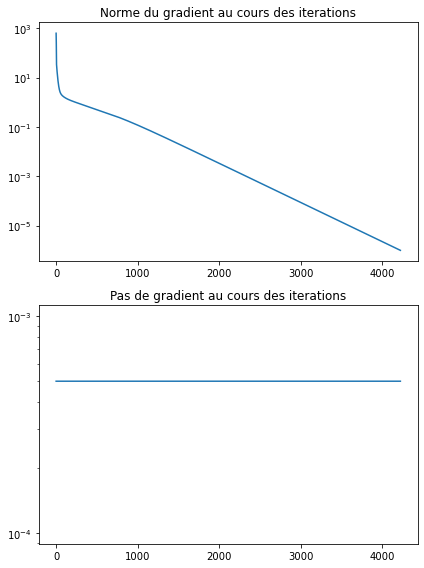


Verification des equations d'equilibre du reseau
Sur les debits : 2.220446049250313e-16
Sur les pressions : 9.988725708787172e-07


In [10]:
x0 = 0.1 * random.normal(size=n-md)
print()
print("MINIMISATION DU PROBLEME PRIMAL")
print()
print("ALGORITHME DU GRADIENT A PAS FIXE")
copt, gopt, xopt,gnl_GF, gsl_GF, cl_GF = Gradient_F(OraclePG, x0, 0.0005)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

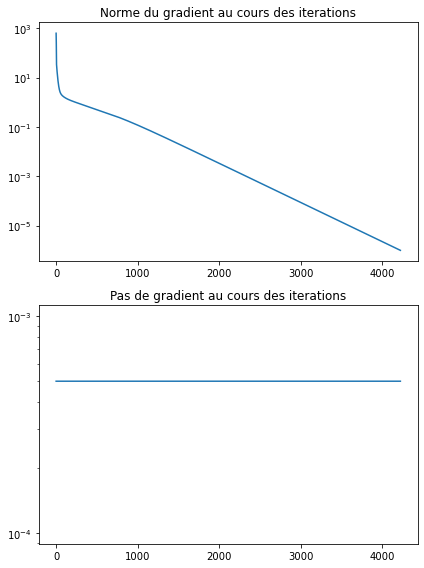

In [11]:
Visualg(gnl_GF, gsl_GF, cl_GF )

- Input variables  
  1. $ gradient \ list$: array containing the norm of the gradient  of the criterion at each iteration of the optimization algorithm.  
  2. $ step \ list $: array containing the length of the gradient step at each iteration.
  3. $ criterere \ list$: array containing the value of the criterion 


MINIMISATION DU PROBLEME PRIMAL

ALGORITHME DE NEWTON A PAS FIXE

Iteration : 6
Temps CPU : 0.015625
Critere optimal : -3.7340070480435745
Norme du gradient : 6.147549404245316e-13


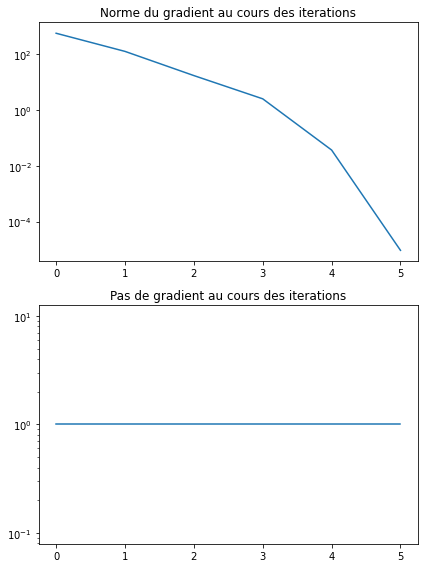


Verification des equations d'equilibre du reseau
Sur les debits : 2.220446049250313e-16
Sur les pressions : 4.414801857421935e-13


In [12]:
x0 = 0.1 * random.normal(size=n-md)
print()
print("MINIMISATION DU PROBLEME PRIMAL")
print()
print("ALGORITHME DE NEWTON A PAS FIXE")
copt, gopt, xopt,gnl_NF, gsl_NF, cl_NF  = Newton_F(OraclePH, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

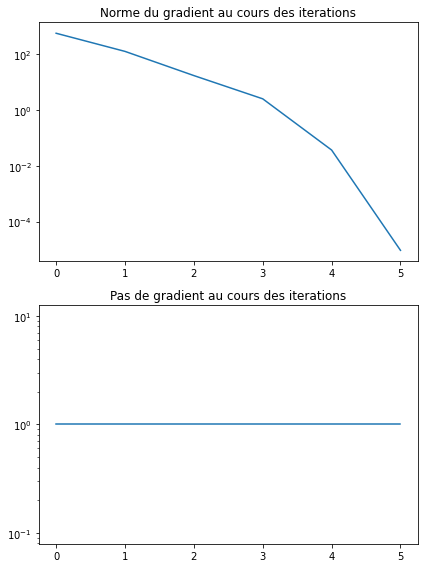

In [13]:
Visualg(gnl_NF, gsl_NF, cl_NF )

### I.b On écrit l'algorithme de recherche linéaire (conditions de Wolfe).

- Notation   
$ x^{k}$  
$g^{k}$ : $ \nabla f(x) $  
$ d^{k}$ : $ \Delta x^{k} $  
$ \alpha^{(k)} $: $t^{k}$






- condition  
$$ f\left(x^{(k)}+\alpha^{(k)} d^{(k)}\right) \leq f\left(x^{(k)}\right)+\omega_{1} \alpha^{(k)} g^{(k)^{\top}} d^{(k)} $$  
$ \Leftrightarrow $  
$$ f(x^{k}+t^{k} \Delta x^{k})>f(x^{k})+ t^{k} \nabla f(x^{k})^{T} \Delta x^{k} $$  
$$ \left(\nabla f\left(x^{(k)}+\alpha^{(k)} d^{(k)}\right)\right)^{\top} d^{(k)} \geq \omega_{2} g^{(k)^{\top}} d^{(k)} $$  
where $ 0<\omega_{1}<\omega_{2}<1 $

In [14]:
cond1 = (1<3)

In [15]:
cond1

True

In [16]:
def Wolfe(alpha, x, D, Oracle):
    
    from numpy import dot
    from numpy import inf
    from numpy.linalg import norm

    ##### Coefficients de la recherche lineaire
    
    omega_1 = 0.1
    omega_2 = 0.9
    
    alpha_min = 0
    alpha_max = inf
    
    ok = 0
    dltx = 0.00000001

    ##### Algorithme de Fletcher-Lemarechal
    
    # Appel de l'oracle au point initial
    #print(Oracle)
    res = Oracle(x)
    critere = res[0]
    gradient = res[1]
    
    # Initialisation de l'algorithme
    alpha_n = alpha
    xn = x
    
    # Boucle de calcul du pas
    # xn represente le point pour la valeur courante du pas,
    # xp represente le point pour la valeur precedente du pas.
    while ok == 0:
        
        # Point precedent pour tester l'indistinguabilite
        xp = xn
        
        # Point actuel
        xn = x + alpha_n*D
        #print("xn: ",xn)
        
        # Calculation of Wolfe conditions
        
        # f(x^k+t^k d^k) gradient_f(x^k+t^k d^k)
        
        res_n = Oracle(xn)
        critere_n = res_n[0]
        gradient_n = res_n[1]
        
        #print("critere_n",critere_n)
        #print("gradient_n",gradient_n)
        # condition 1
        condition1 = (critere_n <= critere+omega_1*alpha_n*gradient.transpose()@D)
        
        # condition 2
        #print(critere_n.transpose())
        #print(D)
        condition2 = (gradient_n.transpose()@D >= omega_2*gradient.transpose()@D)
        
        # ---> To be completed ...
        # ---> To be completed ...
        
        # Test of Wolfe conditions
        #
        # - If both Wolfe conditions are true,
        # set ok = 1: we then exit the while loop
        if condition1 and condition2:
            
            ok = 1
            
        
        # - Otherwise, modify the value of alphan and loop back
        else:
            if not condition1:
                alpha_max = alpha_n
                alpha_n = 1/2 * (alpha_min+alpha_max)
            if not condition2:
                alpha_min = alpha_n
                if alpha_max == inf:
                    alpha_n = 2*alpha_min
                else:
                    alpha_n = 1/2 * (alpha_min+alpha_max)
        
            
            
        # ---> To be completed ...
        # ---> To be completed ...
        
        # Test d'indistinguabilite
        if norm(xn - xp) < dltx:
            ok = 2

    return alpha_n, ok

### I.c On écrit l'algorithme du gradient à pas variable et on le teste

In [17]:
def Gradient_V(Oracle, x0, alpha0):
    
    from numpy.linalg import norm
    from time import process_time
    
    ##### Initialisation des variables

    iter_max = 1000
    default_gradient_step = alpha0
    threshold = 0.000001
    
    gradient_norm_list = []
    gradient_step_list = []
    critere_list = []
    
    time_start = process_time()

    x = x0

    ##### Boucle sur les iterations

    for k in range(iter_max):
        
        # ---> A COMPLETER
        # ---> A COMPLETER
        
        # Valeur du critere et du gradient
        critere, gradient = Oracle(x)
        
        # Test de convergence
        gradient_norm = norm(gradient)
        if gradient_norm <= threshold:
            break

        # Direction de descente
        direction = -gradient
        
        # conditions de Wolfe for step size
        res = Wolfe(default_gradient_step, x, direction, Oracle)
        gradient_step = res[0]
        #print("gradient_n",gradient_step)
        # Mise a jour des variables
        x = x + (gradient_step*direction)
        
        # Evolution du gradient, du pas, et du critere
        gradient_norm_list.append(gradient_norm)
        gradient_step_list.append(gradient_step)

        
        critere_list.append(critere)
    ##### Resultats de l'optimisation
    critere_opt = critere
    gradient_opt = gradient
    x_opt = x
    time_cpu = process_time() - time_start

    print()
    print('Iteration :', k)
    print('Temps CPU :', time_cpu)
    print('Critere optimal :', critere_opt)
    print('Norme du gradient :', norm(gradient_opt))
    
    # Visualisation de la convergence
    Visualg(gradient_norm_list, gradient_step_list, critere_list)
    
    return critere_opt, gradient_opt, x_opt,gradient_norm_list, gradient_step_list, critere_list


MINIMISATION DU PROBLEME PRIMAL

ALGORITHME DU GRADIENT A PAS VARIABLE

Iteration : 321
Temps CPU : 0.59375
Critere optimal : -3.7340070480435283
Norme du gradient : 8.549729762255891e-07


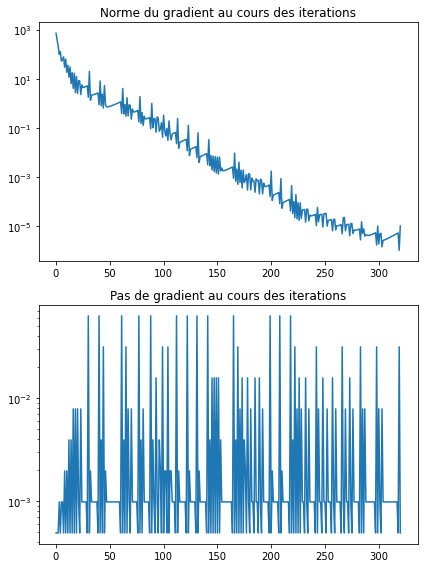


Verification des equations d'equilibre du reseau
Sur les debits : 1.1102230246251565e-16
Sur les pressions : 7.939079135210747e-07


In [18]:
x0 = 0.1 * random.normal(size=n-md)
print()
print("MINIMISATION DU PROBLEME PRIMAL")
print()
print("ALGORITHME DU GRADIENT A PAS VARIABLE")
copt, gopt, xopt,gnl_GV, gsl_GV, cl_GV = Gradient_V(OraclePG, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

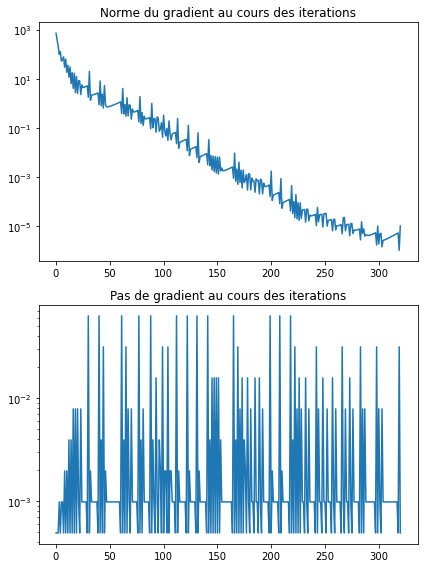

In [19]:
Visualg(gnl_GV, gsl_GV, cl_GV)

### I.d On écrit l'algorithme de gradient conjugué (Polak-Ribière) et on le teste

$ d^{(k)}=\left\{\begin{array}{ll}-g^{(1)} & \text { si } k=1 \\ -g^{(k)}+\beta^{(k)} d^{(k-1)} & \text { sinon }\end{array}\right. $

$ \beta^{(k)}=\frac{g^{(k)^{\top}}\left(g^{(k)}-g^{(k-1)}\right)}{\| g^{(k-1) \|^{2}}} $

In [20]:
a = [1,2,3,4,5]
a[-1]

5

In [21]:
def PolakRibiere(Oracle, x0, alpha0):
    
    from numpy import dot
    from numpy.linalg import norm
    from time import process_time
    
    ##### Initialisation des variables

    iter_max = 1000
    default_gradient_step = alpha0
    threshold = 0.000001
    
    gradient_norm_list = []
    gradient_step_list = []
    gradient_list = []
    critere_list = []
    
    time_start = process_time()

    x = x0
    
    ##### Boucle sur les iterations
    
    for k in range(iter_max):
        
        
        # Valeur du critere et du gradient
        critere, gradient = Oracle(x)
        
        
        # Test de convergence
        gradient_norm = norm(gradient)
        if gradient_norm <= threshold:
            break
        
        # Formule de Polak-Ribi`ere for Direction de descente
        if k == 0:
            direction = -gradient
        else:
            #print("k:", k)
            #print("gradient_list: ",gradient_list)
            #print("gradient_norm_list:",gradient_norm_list)
            beta = gradient.transpose()@(gradient - gradient_list[-1])/(gradient_norm_list[-1] * gradient_norm_list[-1])
            direction = -gradient + beta*direction

        # conditions de Wolfe for step size
        res = Wolfe(default_gradient_step, x, direction, Oracle)
        gradient_step = res[0]
        #gradient_step =  default_gradient_step
        
        # Mise a jour des variables
        x = x + (gradient_step*direction)
        
        # Evolution du gradient, du pas, et du critere
        gradient_norm_list.append(gradient_norm)
        gradient_step_list.append(gradient_step)
        gradient_list.append(gradient)

        
        critere_list.append(critere)
    
    # Resultat de l'optimisation
    critere_opt = critere
    gradient_opt = gradient
    x_opt = x
    time_cpu = process_time() - time_start

    print()
    print('Iteration :', k)
    print('Temps CPU :', time_cpu)
    print('Critere optimal :', critere_opt)
    print('Norme du gradient :', norm(gradient_opt))
        
    # Visualisation de la convergence
    Visualg(gradient_norm_list, gradient_step_list, critere_list)
    
    return critere_opt, gradient_opt, x_opt,gradient_norm_list, gradient_step_list, critere_list


MINIMISATION DU PROBLEME PRIMAL

ALGORITHME DU GRADIENT CONJUGUE

Iteration : 214
Temps CPU : 0.40625
Critere optimal : -3.7340070480435603
Norme du gradient : 7.177834913244605e-07


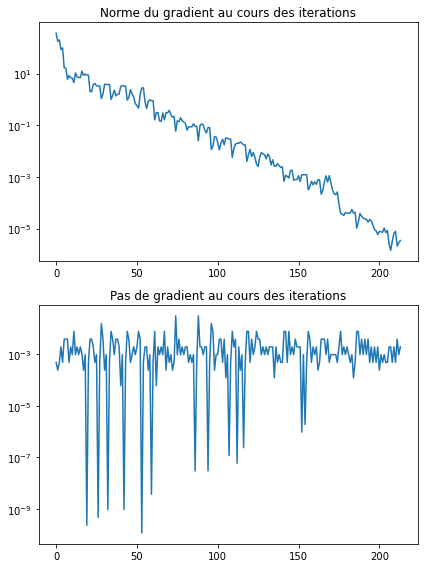


Verification des equations d'equilibre du reseau
Sur les debits : 1.1102230246251565e-16
Sur les pressions : 4.72677894158835e-07


In [22]:
x0 = 0.1 * random.normal(size=n-md)
print()
print("MINIMISATION DU PROBLEME PRIMAL")
print()
print("ALGORITHME DU GRADIENT CONJUGUE")
copt, gopt, xopt,gnl_GC, gsl_GC, cl_GC = PolakRibiere(OraclePG, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

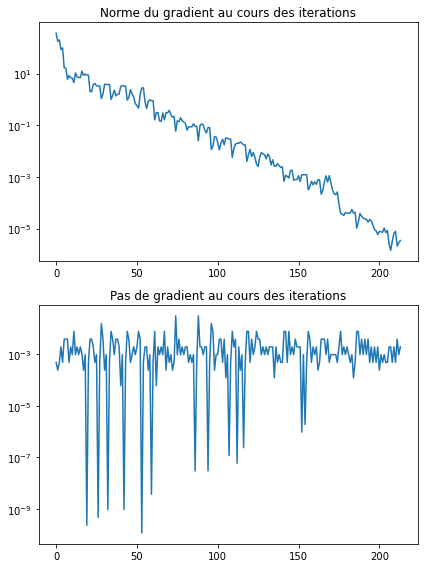

In [23]:
Visualg(gnl_GC, gsl_GC, cl_GC)

### I.e On écrit l'algorithme de quasi-Newton (BFGS) et on le teste

$ d^{(k)}=-W^{(k)} g^{(k)} $  
$ \delta_{x}^{(k)}=x^{(k)}-x^{(k-1)} $  
$ \delta_{g}^{(k)}=g^{(k)}-g^{(k-1)} $  
$ W^{(k)}=\left(I-\frac{\delta_{x}^{(k)} \delta_{g}^{(k)} \top}{\delta_{g}^{(k)^{\top}} \delta_{x}^{(k)}}\right) W^{(k-1)}\left(I-\frac{\delta_{g}^{(k)} \delta_{x}^{(k)} \top}{\delta_{g}^{(k)^{\top}} \delta_{x}^{(k)}}\right)+\frac{\left.\delta_{x}^{(k)} \delta_{x}^{(k)}\right)^{\top}}{\delta_{g}^{(k)} \delta_{x}^{(k)}} $  

In [24]:
def BFGS(Oracle, x0, alpha0):
    import numpy as np
    from numpy.linalg import solve
    from numpy import dot
    from numpy import eye
    from numpy import outer
    from numpy import vdot
    from numpy.linalg import norm
    from time import process_time
    
    ##### Initialisation des variables

    iter_max = 250
    default_gradient_step = alpha0
    threshold = 0.000001
    
    gradient_norm_list = []
    gradient_step_list = []
    gradient_list = []
    critere_list = []
    x_list = []
    
    time_start = process_time()

    x = x0
    I = eye(len(x0))
    
    ##### Boucle sur les iterations
    
    for k in range(iter_max):
        
        
        # Valeur du critere et du gradient
        res = Oracle(x)
        critere = res[0]
        gradient = res[1]
        #hessien = res[2]
        
        # Test de convergence
        gradient_norm = norm(gradient)
        if gradient_norm <= threshold:
            break
                # Valeur du critere et du gradient
        
        # Direction de descente
        #direction_n = - solve(hessien, gradient)
        #print("direction_n",direction_n)
        
        # Formule de BFGS inverse for Direction de descente
        #print("k:",k)
        if k == 0:
            Wk = I 
            #print("Wk",Wk)
        else:
            #print("gradient",gradient)
            #print("gradient_list[-1]",gradient_list[-1])
            delta_xk = np.array([list(x - x_list[-1])]).transpose()
            delta_gk = np.array([list(gradient - gradient_list[-1])]).transpose()
            
            #print("delta_xk",delta_xk)
            #print("delta_gk",delta_gk)
            
            #print("(delta_xk@delta_gk.transpose())",(delta_xk@delta_gk.transpose()))
            
            A = I - np.multiply(delta_xk,delta_gk.transpose())/(delta_gk.transpose()@delta_xk)
            B = I - np.multiply(delta_gk,delta_xk.transpose())/(delta_gk.transpose()@delta_xk)
            C = (np.multiply(delta_xk,delta_xk.transpose()))/(delta_gk.transpose()@delta_xk)
            #print("A:",A)
            #print("B:",B)
            #print("C:",C)
                        
            Wk = A@Wk@B + C


            #print("Wk",Wk)
            #print("Hessien", hessien)
        direction = -Wk@gradient
        #print("direction",direction)
        
        # Direction de descente
        #direction = - solve(hessien, gradient)
        
        # conditions de Wolfe for step size
        res = Wolfe(default_gradient_step, x, direction, Oracle)
        gradient_step = res[0]
        
        #gradient_step =  default_gradient_step

        
        # Mise a jour des variables
        x_list.append(x)
        x = x + (gradient_step*direction)
        
        # Evolution du gradient, du pas, et du critere
        gradient_norm_list.append(gradient_norm)
        gradient_step_list.append(gradient_step)
        gradient_list.append(gradient)
        critere_list.append(critere)
    
    # Resultat de l'optimisation
    critere_opt = critere
    gradient_opt = gradient
    x_opt = x
    time_cpu = process_time() - time_start

    print()
    print('Iteration :', k)
    print('Temps CPU :', time_cpu)
    print('Critere optimal :', critere_opt)
    print('Norme du gradient :', norm(gradient_opt))
        
    # Visualisation de la convergence
    Visualg(gradient_norm_list, gradient_step_list, critere_list)
    
    return critere_opt, gradient_opt, x_opt,gradient_norm_list, gradient_step_list, critere_list


MINIMISATION DU PROBLEME PRIMAL

ALGORITHME DE QUASI-NEWTON

Iteration : 23
Temps CPU : 0.03125
Critere optimal : -3.734007048043571
Norme du gradient : 2.220149804937683e-07


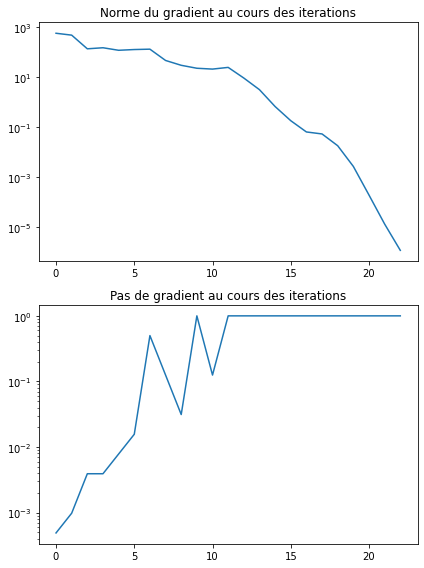


Verification des equations d'equilibre du reseau
Sur les debits : 2.220446049250313e-16
Sur les pressions : 1.525684885095302e-07


In [25]:
x0 = 0.1 * random.normal(size=n-md)
print()
print("MINIMISATION DU PROBLEME PRIMAL")
print()
print("ALGORITHME DE QUASI-NEWTON")
copt, gopt, xopt,gnl_QN, gsl_QN, cl_QN = BFGS(OraclePG, x0, 1)
#copt, gopt, xopt = Newton_N(OraclePH, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

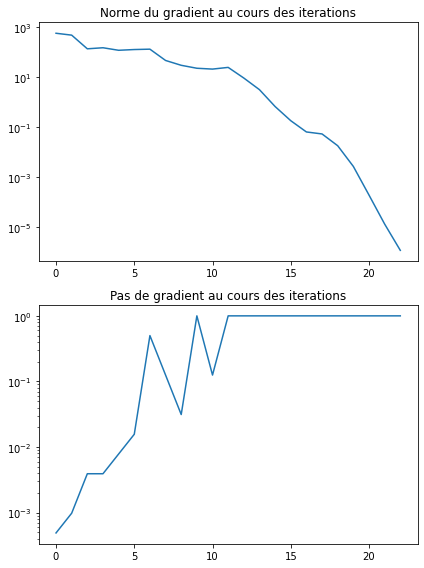

In [26]:
Visualg(gnl_QN, gsl_QN, cl_QN)

In [27]:
# experiment of comparison
x0 = 0.1 * random.normal(size=n-md)
print()
print("MINIMISATION DU PROBLEME PRIMAL")


MINIMISATION DU PROBLEME PRIMAL


ALGORITHME DU GRADIENT A PAS FIXE

Iteration : 3957
Temps CPU : 0.453125
Critere optimal : -3.7340070480435
Norme du gradient : 9.984468154399097e-07


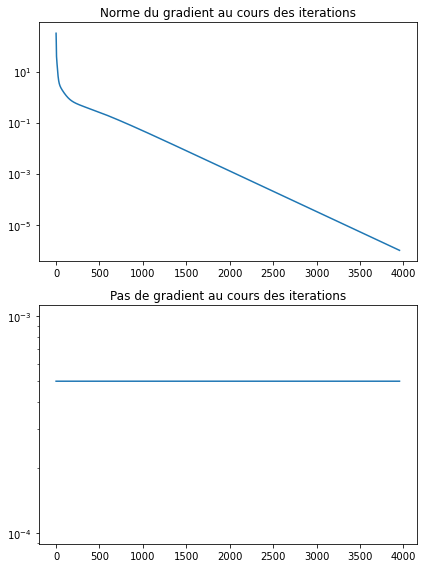


Verification des equations d'equilibre du reseau
Sur les debits : 2.220446049250313e-16
Sur les pressions : 9.984420770159375e-07


In [29]:
print("ALGORITHME DU GRADIENT A PAS FIXE")
copt, gopt, xopt,gnl_GF, gsl_GF, cl_GF = Gradient_F(OraclePG, x0, 0.0005)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

ALGORITHME DE NEWTON A PAS FIXE

Iteration : 5
Temps CPU : 0.046875
Critere optimal : -3.7340070480435763
Norme du gradient : 2.3324847955473776e-11


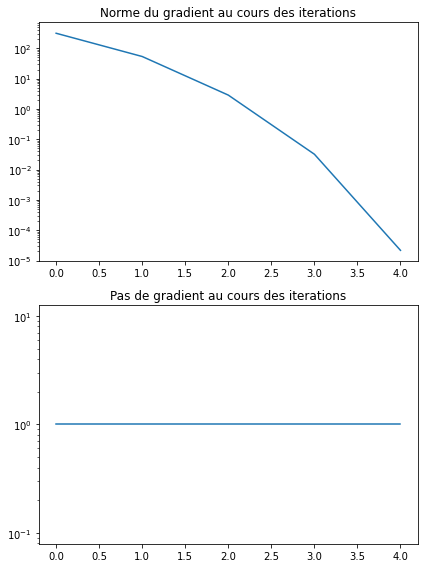


Verification des equations d'equilibre du reseau
Sur les debits : 9.71445146547012e-17
Sur les pressions : 1.999262908003452e-11


In [30]:
print("ALGORITHME DE NEWTON A PAS FIXE")
copt, gopt, xopt,gnl_NF, gsl_NF, cl_NF  = Newton_F(OraclePH, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

ALGORITHME DU GRADIENT A PAS VARIABLE

Iteration : 259
Temps CPU : 0.484375
Critere optimal : -3.7340070480435035
Norme du gradient : 9.980616892539242e-07


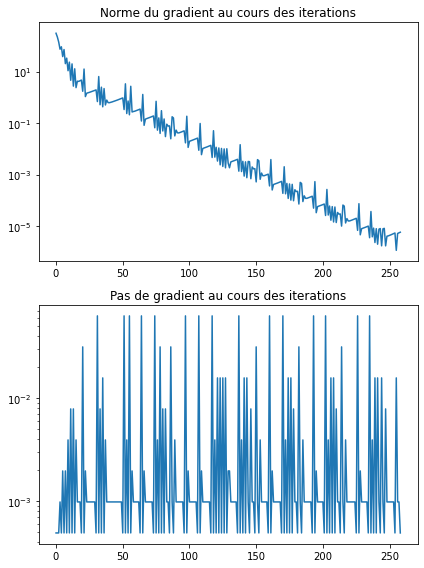


Verification des equations d'equilibre du reseau
Sur les debits : 1.1102230246251565e-16
Sur les pressions : 9.598970013291463e-07


In [31]:
print("ALGORITHME DU GRADIENT A PAS VARIABLE")
copt, gopt, xopt,gnl_GV, gsl_GV, cl_GV = Gradient_V(OraclePG, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

ALGORITHME DU GRADIENT CONJUGUE

Iteration : 189
Temps CPU : 0.296875
Critere optimal : -3.7340070480435656
Norme du gradient : 9.772456840615705e-07


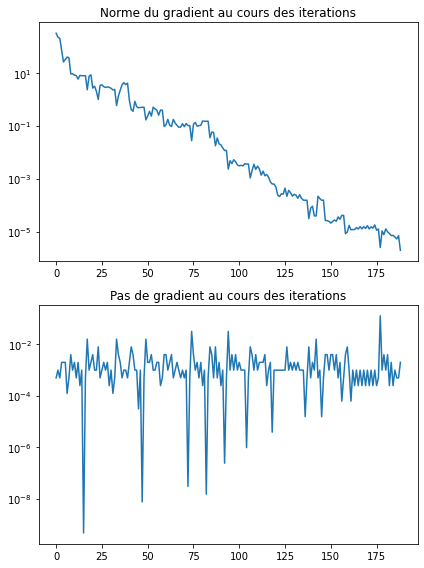


Verification des equations d'equilibre du reseau
Sur les debits : 2.220446049250313e-16
Sur les pressions : 5.908401026211152e-07


In [33]:
print("ALGORITHME DU GRADIENT CONJUGUE")
copt, gopt, xopt,gnl_GC, gsl_GC, cl_GC = PolakRibiere(OraclePG, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

ALGORITHME DE QUASI-NEWTON

Iteration : 20
Temps CPU : 0.03125
Critere optimal : -3.7340070480435728
Norme du gradient : 8.550875761754614e-07


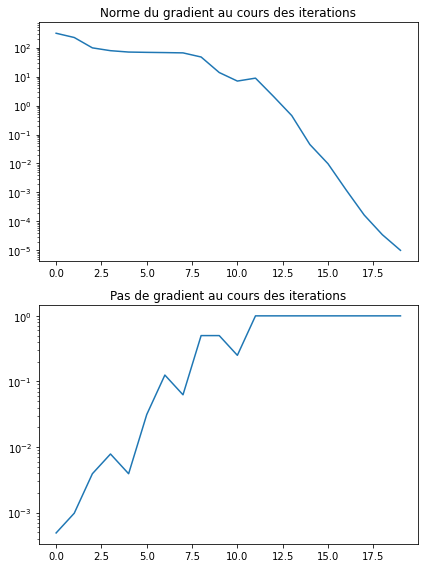


Verification des equations d'equilibre du reseau
Sur les debits : 1.3877787807814457e-16
Sur les pressions : 6.840609456659763e-07


In [34]:
print("ALGORITHME DE QUASI-NEWTON")
copt, gopt, xopt,gnl_QN, gsl_QN, cl_QN = BFGS(OraclePG, x0, 1)
#copt, gopt, xopt = Newton_N(OraclePH, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

In [45]:
def Visualg2(gradient_lists, step_lists, criterere_lists): 

    import matplotlib.pyplot as plt 
    
    plt.subplot (2, 1, 1) 
    plt.gca().set_title ("Gradient norm during iterations") 
    plt.gca().set_yscale ('log') 
    plt.plot(gradient_lists[0], label = "Gradient norm_Algorithm1")
    plt.plot(gradient_lists[1], label = "Gradient norm_Algorithm2") 
    plt.plot(gradient_lists[2], label = "Gradient norm_Algorithm3") 
    
    plt.subplot (2, 1, 2) 
    
    plt.gca().set_title("Stepsize during iterations") 
    plt.gca().set_yscale('log')
    plt.plot(step_lists[0], label = "Step length_Algorithm1") 
    plt.plot(step_lists[1], label = "Step length_Algorithm2") 
    plt.plot(step_lists[2], label = "Step length_Algorithm3") 
    
    plt.tight_layout (rect = (0, 0, 1, 2)) 
    plt.show ()

In [46]:
gradient_lists = [gnl_GF,gnl_GV,gnl_GC]
step_lists = [gsl_GF, gsl_GV, gsl_GC]
criterere_lists = [cl_GF, cl_GV, cl_GC]

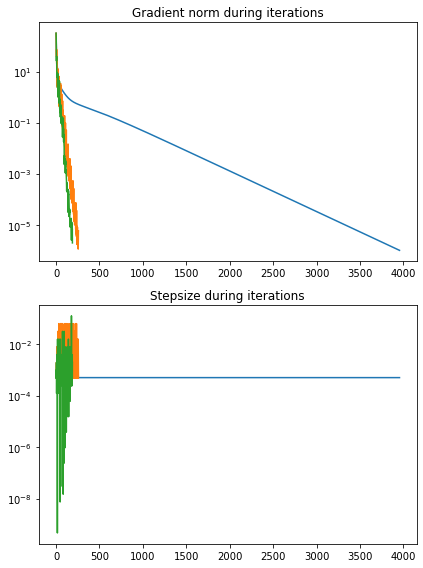

In [47]:
Visualg2(gradient_lists, step_lists, criterere_lists)

### I.f On écrit l'algorithme de Newton à pas variable et on le teste

In [ ]:
def Newton_V(Oracle, x0, alpha0):
    
    from numpy.linalg import norm
    from numpy.linalg import solve
    from time import process_time
    
    ##### Initialisation des variables  
    
    iter_max = 100
    default_gradient_step = alpha0
    threshold = 0.000001
    
    gradient_norm_list = []
    gradient_step_list = []
    critere_list = []

    time_start = process_time()
    
    x = x0

    ##### Boucle sur les iterations
    
    for k in range(iter_max):
        
        # ---> A COMPLETER
        # ---> A COMPLETER
           
    ##### Resultats de l'optimisation
    
    critere_opt = critere
    gradient_opt = gradient
    x_opt = x
    time_cpu = process_time() - time_start

    print()
    print('Iteration :', k)
    print('Temps CPU :', time_cpu)
    print('Critere optimal :', critere_opt)
    print('Norme du gradient :', norm(gradient_opt))
    
    # Visualisation de la convergence
    Visualg(gradient_norm_list, gradient_step_list, critere_list)
    
    return critere_opt, gradient_opt, x_opt

In [ ]:
x0 = 0.1 * random.normal(size=n-md)
print()
print("MINIMISATION DU PROBLEME PRIMAL")
print()
print("ALGORITHME DE NEWTON A PAS VARIABLE")
copt, gopt, xopt = Newton_V(OraclePH, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

## II. Résolution du problème dual

In [ ]:
from HydrauliqueD import HydrauliqueD

### II.a On écrit les oracles pour le problème dual d'optimisation :

* **OracleDG** : calcul de la fonction et du gradient,
* **OracleDH** : calcul de la fonction du gradient et du Hessien.

In [ ]:
def OracleDG(pd):
    
    # ---> A COMPLETER
    # ---> A COMPLETER
    
    return critere, gradient

In [ ]:
def OracleDH(pd):
    
    # ---> A COMPLETER
    # ---> A COMPLETER
    
    return critere, gradient, hessien

### II.b On exécute tous les algorithmes d'optimisation déjà écrits

In [ ]:
x0 = 100 + random.normal(size=md)
print()
print("MINIMISATION DU PROBLEME DUAL")
print()
print("ALGORITHME DU GRADIENT A PAS VARIABLE")
copt, gopt, xopt = Gradient_V(OracleDG, x0, 5)
qopt, zopt, fopt, popt = HydrauliqueD(xopt, m, mr, r, pr, fd, A, Ar)
Verification(A, qopt, zopt, fopt, popt)

In [ ]:
x0 = 100 + random.normal(size=md)
print()
print("MINIMISATION DU PROBLEME DUAL")
print()
print("ALGORITHME DU GRADIENT CONJUGUE")
copt, gopt, xopt = PolakRibiere(OracleDG, x0, 5)
qopt, zopt, fopt, popt = HydrauliqueD(xopt, m, mr, r, pr, fd, A, Ar)
Verification(A, qopt, zopt, fopt, popt)

In [ ]:
x0 = 100 + random.normal(size=md)
print()
print("MINIMISATION DU PROBLEME DUAL")
print()
print("ALGORITHME DE QUASI-NEWTON")
copt, gopt, xopt = BFGS(OracleDG, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueD(xopt, m, mr, r, pr, fd, A, Ar)
Verification(A, qopt, zopt, fopt, popt)

In [ ]:
x0 = 100 + random.normal(size=md)
print()
print("MINIMISATION DU PROBLEME DUAL")
print()
print("ALGORITHME DE NEWTON A PAS VARIABLE")
copt, gopt, xopt = Newton_V(OracleDH, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueD(xopt, m, mr, r, pr, fd, A, Ar)
Verification(A, qopt, zopt, fopt, popt)

## III. Résolution de grands réseaux (facultatif)

### On charge dans l'environnement les données du problème

Ces données correspondent à un réseau de taille paramétrable.

In [ ]:
from Probleme_P import *
from Structures_S import *

### III.a On écrit des oracles primal et dual avec Hessien creux

In [ ]:
def OraclePHS(qc):
    
    # ---> A COMPLETER
    # ---> A COMPLETER
    
    return critere, gradient, hessien

In [ ]:
def OracleDHS(pd):
    
    # ---> A COMPLETER
    # ---> A COMPLETER
    
    return critere, gradient, hessien

### III.b On écrit un algorithme de Newton exploitant le creux

In [ ]:
def Newton_S(Oracle, x0, alpha0):
    
    from numpy.linalg import norm
    from scipy.sparse.linalg import spsolve
    from time import process_time
    
    ##### Initialisation des variables  
    
    iter_max = 100
    default_gradient_step = alpha0
    threshold = 0.000001
    
    gradient_norm_list = []
    gradient_step_list = []
    critere_list = []

    time_start = process_time()
    
    x = x0

    ##### Boucle sur les iterations
    
    for k in range(iter_max):
        
        # ---> A COMPLETER
        # ---> A COMPLETER
           
    ##### Resultats de l'optimisation
    
    critere_opt = critere
    gradient_opt = gradient
    x_opt = x
    time_cpu = process_time() - time_start

    print()
    print('Iteration :', k)
    print('Temps CPU :', time_cpu)
    print('Critere optimal :', critere_opt)
    print('Norme du gradient :', norm(gradient_opt))
    
    # Visualisation de la convergence
    Visualg(gradient_norm_list, gradient_step_list, critere_list)
    
    return critere_opt, gradient_opt, x_opt

### III.c On résoud le problème dans le primal et dans le dual

In [ ]:
x0 = 0.1 * random.normal(size=n-md)
print()
print("MINIMISATION DU PROBLEME PRIMAL DE GRANDE TAILLE")
print()
print("ALGORITHME DE NEWTON A PAS VARIABLE")
copt, gopt, xopt = Newton_S(OraclePHS, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueP(xopt, m, mr, md, r, pr, fd, Ar, AdI, B, q0)
Verification(A, qopt, zopt, fopt, popt)

In [ ]:
x0 = 100 + random.normal(size=md)
print()
print("MINIMISATION DU PROBLEME DUAL DE GRANDE TAILLE")
print()
print("ALGORITHME DE NEWTON A PAS VARIABLE")
copt, gopt, xopt = Newton_S(OracleDHS, x0, 1)
qopt, zopt, fopt, popt = HydrauliqueD(xopt, m, mr, r, pr, fd, A, Ar)
Verification(A, qopt, zopt, fopt, popt)